读取数据成功: /home/iris/文档/Final_Proj_2010/parkinsons+telemonitoring/parkinsons_updrs.data
原始形状: (5875, 22)
特征列数: 18
特征列: ['age', 'sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
Train 形状: (4700, 19) Val 形状: (1175, 19)


2025-12-08 23:45:33,066 - {pytorch_tabular.tabular_model:171} - INFO - Experiment Tracking is turned off

2025-12-08 23:45:33,071 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/iris/miniconda3/envs/struct/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


已从目录加载模型: ft_model
模型中的 continuous_cols: ['age', 'sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
模型中的 categorical_cols: []
Registered hook on layer 5 -> _backbone.transformer_blocks.mha_block_0.mha
Registered hook on layer 23 -> _backbone.transformer_blocks.mha_block_1.mha
Registered hook on layer 41 -> _backbone.transformer_blocks.mha_block_2.mha
Registered hook on layer 59 -> _backbone.transformer_blocks.mha_block_3.mha
Layer 5: 收集到 5 个 batch 的 attention，第一个张量形状: torch.Size([256, 8, 19, 19])
Layer 23: 收集到 5 个 batch 的 attention，第一个张量形状: torch.Size([256, 8, 19, 19])
Layer 41: 收集到 5 个 batch 的 attention，第一个张量形状: torch.Size([256, 8, 19, 19])
Layer 59: 收集到 5 个 batch 的 attention，第一个张量形状: torch.Size([256, 8, 19, 19])


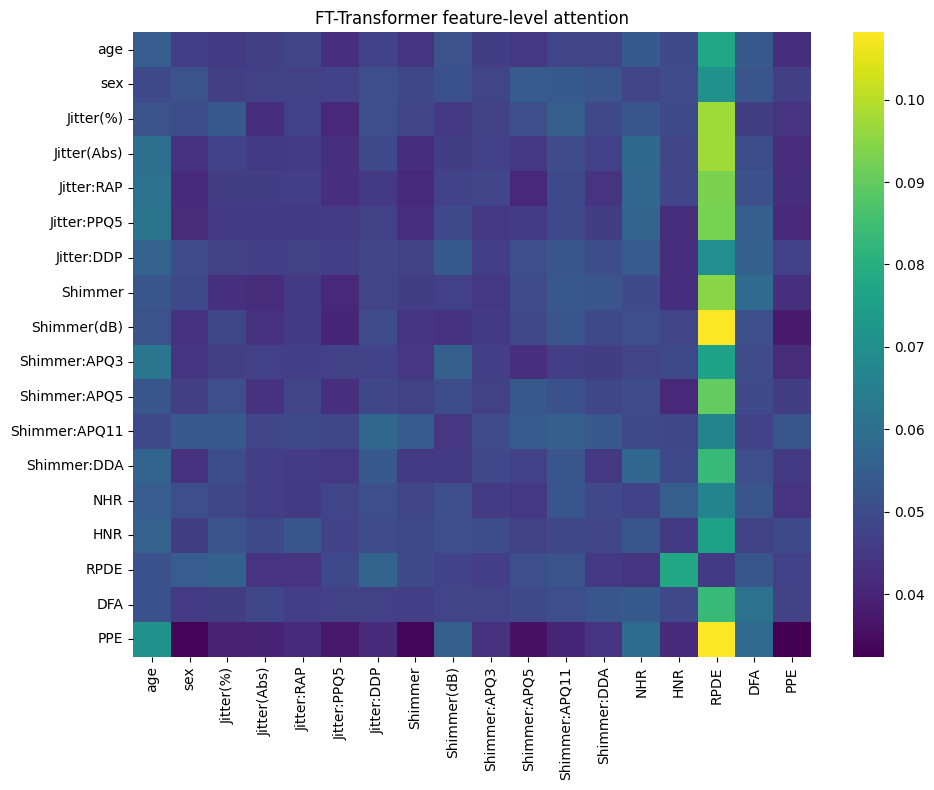

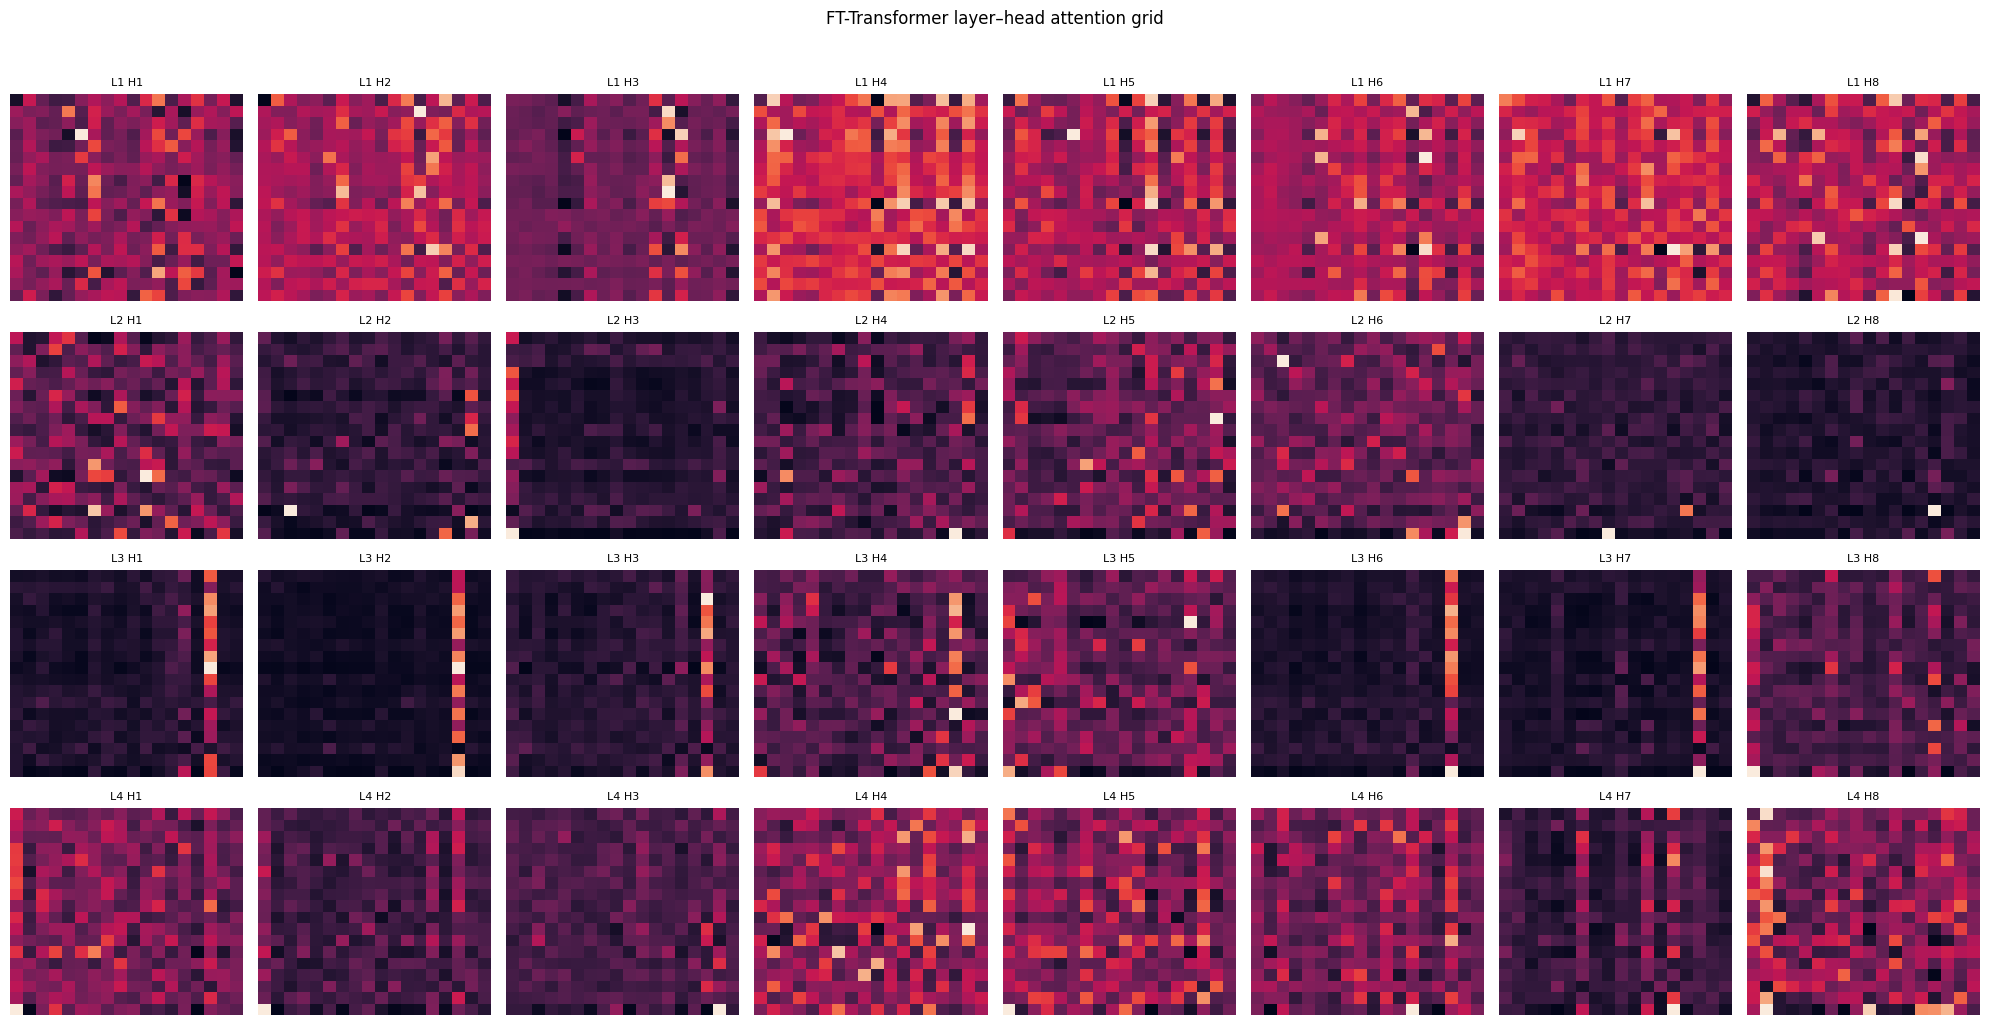

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import os
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from pytorch_tabular import TabularModel
from pytorch_tabular.models.common.layers.transformers import MultiHeadedAttention
from pytorch_lightning.callbacks import Callback


class LossRecorder(Callback):
    pass

Tk().withdraw()
DATA_PATH = askopenfilename(title="Select the UPDRS data file")

df = pd.read_csv(DATA_PATH) # 比如 "data/parkinsons_updrs.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"找不到数据文件 {DATA_PATH}，请把 DATA_PATH 改成你自己的 csv 路径"
    )

df = pd.read_csv(DATA_PATH)
print("读取数据成功:", DATA_PATH)
print("原始形状:", df.shape)


df.columns = [c.strip() for c in df.columns]


target_col = "total_UPDRS"

drop_cols = ["subject#", "motor_UPDRS", "total_UPDRS", "test_time"]
feature_cols = [c for c in df.columns if c not in drop_cols]

print("特征列数:", len(feature_cols))
print("特征列:", feature_cols)


model_df = df[feature_cols + [target_col]].copy()

train_df, val_df = train_test_split(model_df, test_size=0.2, random_state=42)
print("Train 形状:", train_df.shape, "Val 形状:", val_df.shape)




MODEL_DIR = "ft_model"  

if not os.path.exists(MODEL_DIR):
    raise FileNotFoundError(
        f"找不到模型目录 {MODEL_DIR}，请确认在原 notebook 里调用过 "
        "tabular_model.save_model('ft_model')"
    )

tabular_model = TabularModel.load_model(MODEL_DIR)
print("已从目录加载模型:", MODEL_DIR)


cont_cols = list(tabular_model.config.continuous_cols)
cat_cols = list(getattr(tabular_model.config, "categorical_cols", []))
print("模型中的 continuous_cols:", cont_cols)
print("模型中的 categorical_cols:", cat_cols)


val_df = val_df.copy()
for col in cont_cols:
    if col in val_df.columns:
        val_df[col] = val_df[col].astype("float32")

for col in cat_cols:
    if col in val_df.columns:
        val_df[col] = val_df[col].astype("category")



attn_maps = {}


def make_hook(layer_idx):
    def hook(module, input, output):
       
        if hasattr(module, "attn_weights"):
            attn_maps[layer_idx].append(module.attn_weights.detach().cpu())

    return hook


for layer_idx, (name, module) in enumerate(tabular_model.model.named_modules()):
    if isinstance(module, MultiHeadedAttention):
        attn_maps[layer_idx] = []
        module.register_forward_hook(make_hook(layer_idx))
        print("Registered hook on layer", layer_idx, "->", name)


_ = tabular_model.predict(val_df)

for k, v_list in attn_maps.items():
    print(
        f"Layer {k}: 收集到 {len(v_list)} 个 batch 的 attention，"
        "第一个张量形状:",
        v_list[0].shape if v_list else None,
    )


all_tensors = []
for tensors in attn_maps.values():
    if len(tensors) > 0:
        all_tensors.extend(tensors)

if len(all_tensors) == 0:
    raise RuntimeError("attn_maps 里是空的，说明 hook 没有被触发，请检查上面的输出。")

# all_attn: [N_total, H, T, T]
all_attn = torch.cat(all_tensors, dim=0)


all_attn = all_attn.mean(dim=1)


attn_mean = all_attn.mean(dim=0).numpy()


attn_feat = attn_mean[1:, 1:]

# [CLS] + categorical + continuous
feature_names = list(cat_cols) + list(cont_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(
    attn_feat,
    xticklabels=feature_names,
    yticklabels=feature_names,
    cmap="viridis",
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("FT-Transformer feature-level attention")
plt.tight_layout()
plt.show()



layer_attn = {}
for layer_idx, tensors in attn_maps.items():
    if len(tensors) == 0:
        continue
    stacked = torch.cat(tensors, dim=0)  # [N_batch, H, T, T]
    mean_attn = stacked.mean(dim=0)      # [H, T, T]
    layer_attn[layer_idx] = mean_attn

layer_ids = sorted(layer_attn.keys())
L = len(layer_ids)
H = layer_attn[layer_ids[0]].shape[0]  

fig, axes = plt.subplots(L, H, figsize=(2.5 * H, 2.5 * L))
if L == 1:
    axes = np.expand_dims(axes, 0)

for li, layer_idx in enumerate(layer_ids):
    attn_l = layer_attn[layer_idx]  # [H, T, T]
    for h in range(H):
        ax = axes[li, h] if H > 1 else axes[li, 0]
        attn_lh = attn_l[h].numpy()
        attn_lh = attn_lh[1:, 1:] 

        sns.heatmap(
            attn_lh,
            ax=ax,
            xticklabels=[],
            yticklabels=[],
            cbar=False,
        )
        ax.set_title(f"L{li+1} H{h+1}", fontsize=8)

plt.suptitle("FT-Transformer layer–head attention grid", y=1.02)
plt.tight_layout()
plt.show()
